# Classify Benign or Malignant

Here [Breast Cancer](https://www.kaggle.com/karteek93/breast-cancer) by [karteek menda](https://www.kaggle.com/karteek93) is used to create a `machine learning` model to classify `Breast Cancer`. `EDA` is `Bengin` or `Malignant`.

![](https://media.giphy.com/media/fzZzoftMBR8is/giphy.gif)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, learning_curve
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix
import itertools
from sklearn.pipeline import Pipeline
from joblib import dump

In [2]:
def load_dataset():
    path = '/kaggle/input/breast-cancer/cell_samples.csv'
    return pd.read_csv(path)


df = load_dataset()
df.sample(5)

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
668,1350319,5,7,4,1,6,1,7,10,3,4
341,810104,1,1,1,1,2,1,3,1,1,2
39,1091262,2,5,3,3,6,7,7,5,1,4
578,695219,1,1,1,1,2,1,2,1,1,2
107,1170420,1,6,8,10,8,10,5,7,1,4


 benign (value = 2) or malignant (value = 4)

## Data Preparation

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           699 non-null    int64 
 1   Clump        699 non-null    int64 
 2   UnifSize     699 non-null    int64 
 3   UnifShape    699 non-null    int64 
 4   MargAdh      699 non-null    int64 
 5   SingEpiSize  699 non-null    int64 
 6   BareNuc      699 non-null    object
 7   BlandChrom   699 non-null    int64 
 8   NormNucl     699 non-null    int64 
 9   Mit          699 non-null    int64 
 10  Class        699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


The above info tells us that the data doesn't has any null values, but missing data can be in other forms too. All the above data are numeric but the column `BareNuc's`dtype is `object`, so checking it unique value

In [4]:
print(df.BareNuc.unique().tolist())
# `BareNuc` column has missing data

# replacing missing values with nan
df.BareNuc.replace('?', np.nan, inplace=True)
print(df.BareNuc.unique().tolist())

# converting dtype
df.BareNuc = df.BareNuc.astype(np.float64)

['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6']
['1', '10', '2', '4', '3', '9', '7', nan, '5', '8', '6']


In [5]:
print(f'BareNuc column has {len(df[df.BareNuc.isnull()])} missing values')

BareNuc column has 16 missing values


In [6]:
def plot_histplot(column):
    sns.histplot(x=column, color='#adfc03', alpha=.7) 
    

def plot_scatterplot(x_column, y_column):
    sns.scatterplot(x=x_column, y=y_column, color='#fc03ad', alpha=.7, s=80)
    
    
def plot_stripplot(x_column, y_column):
    sns.stripplot(
        x=x_column, y=y_column,
        color='#3b3b3b', alpha=.7, jitter=.1
    )
    
    
def plot_countplot(column):
    sns.countplot(x=column, color='#4aff95', alpha=.7)
    
    
def plot_corr(df):
    # the `corr` method uses pearson correaltion
    corr = df.corr()
    
    _, ax = plt.subplots(1, 1, figsize=(12, 6))
    g = sns.heatmap(corr, ax=ax, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))

    for _ax in g.get_xticklabels():
        _ax.set_rotation(75)
        
        
def plot_boxplot(column):
    sns.boxplot(x=df.Class, y=column)

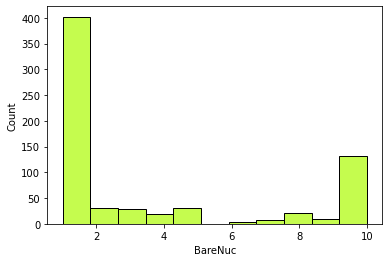

In [7]:
plot_histplot(df.BareNuc)

# The data points majorly have 1 as their value
# so replacing missing values with that
df.BareNuc.fillna(1, inplace=True)

`Missing values` problem solved

In [8]:
def drop_column(df, column_name, inplace=True):
    return df.drop([column_name], axis='columns', inplace=inplace)


drop_column(df, 'ID')

## EDA

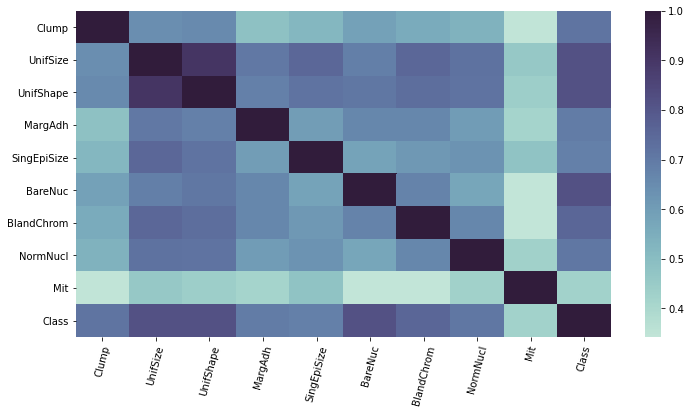

In [9]:
plot_corr(df)

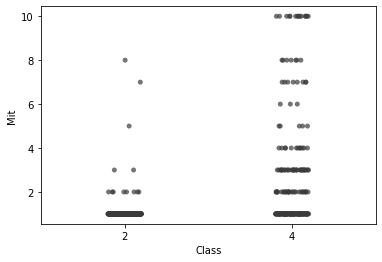

In [10]:
plot_stripplot(df.Class, df.Mit)

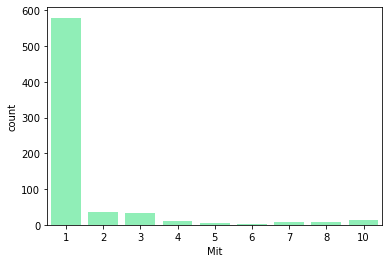

In [11]:
plot_countplot(df.Mit)

In [12]:
df.columns

Index(['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc',
       'BlandChrom', 'NormNucl', 'Mit', 'Class'],
      dtype='object')

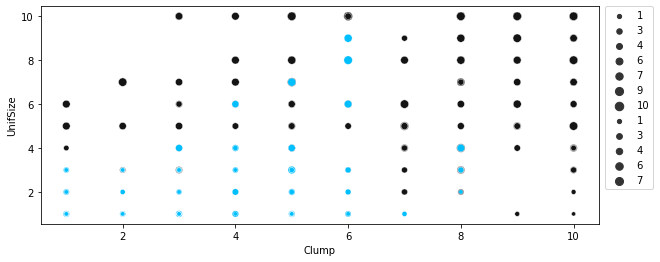

In [13]:
_, ax = plt.subplots(figsize=(10, 4))
sns.scatterplot(x='Clump', y='UnifSize', size='UnifShape', data=df[df.Class == 4], color='#141414', s=80, ax=ax)
sns.scatterplot(x='Clump', y='UnifSize', size='UnifShape', data=df[df.Class == 2], color='#00bfff', s=80, ax=ax)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

# black == 4
# blue == 2

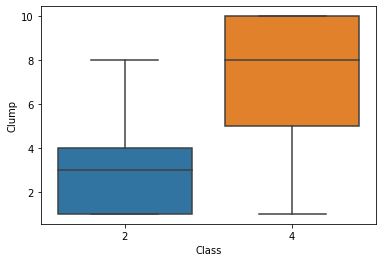

In [14]:
plot_boxplot(df.Clump)
# malignant has higher clump

In [15]:
df.columns

Index(['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc',
       'BlandChrom', 'NormNucl', 'Mit', 'Class'],
      dtype='object')

In [16]:
def plot_box_and_count(df, column_name):
    _, ax = plt.subplots(1, 2, figsize=(20, 4))
    sns.boxplot(x=df.Class, y=df[column_name], ax=ax[0])
    sns.countplot(x=column_name, data=df[df.Class == 2], color='#7300ff', ax=ax[1])
    ax[1].set_xlabel(f'Benign - {column_name}')

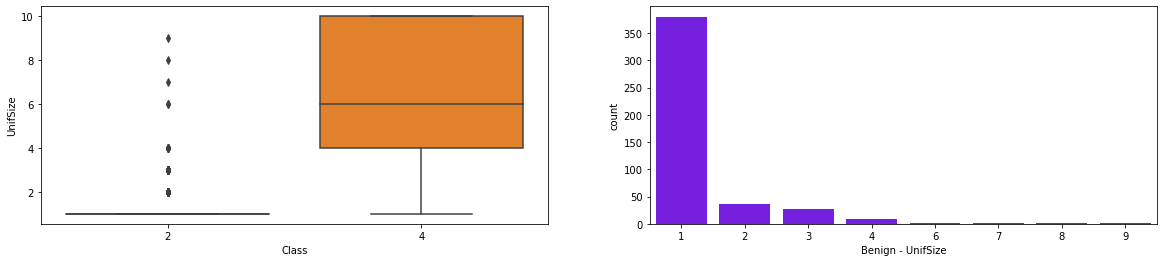

In [17]:
plot_box_and_count(df, 'UnifSize')

# benign has most of the UnifSize as 1 which also explains the bloxplot
# by looking at both countplot & boxplot we can say that malignant has much higher  
# UnifSize

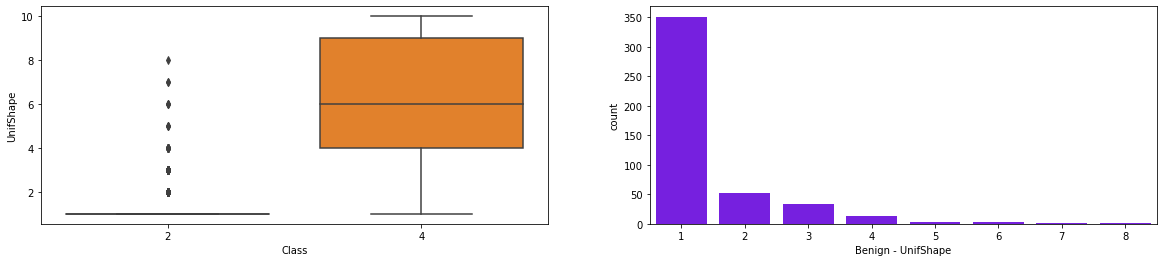

In [18]:
plot_box_and_count(df, 'UnifShape')
# UnifShape case is also similar to UnifSize

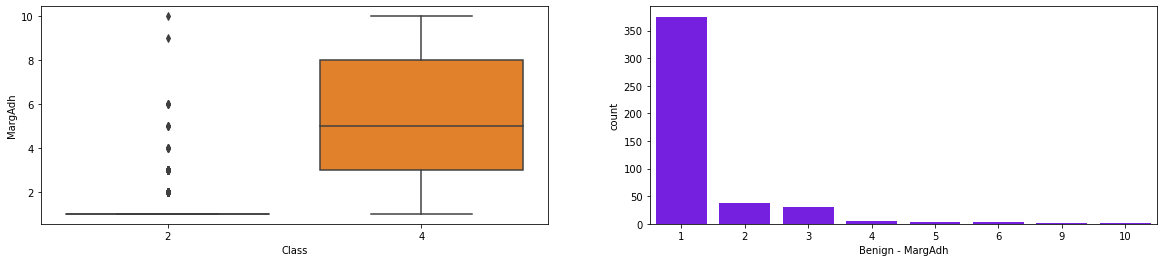

In [19]:
plot_box_and_count(df, 'MargAdh')

# MargAdh case is also similar to UnifSize
# But unlike UnifShape & UnifSize here malignant is not too big
# but it is surely bigger than benign

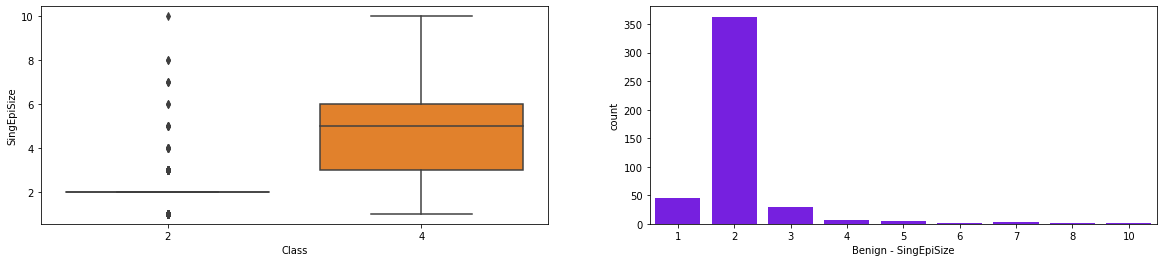

In [20]:
plot_box_and_count(df, 'SingEpiSize')

# SingEpiSize case is also similar to UnifSize
# But unlike UnifShape & UnifSize here malignant is not that big
# but it is surely bigger than benign

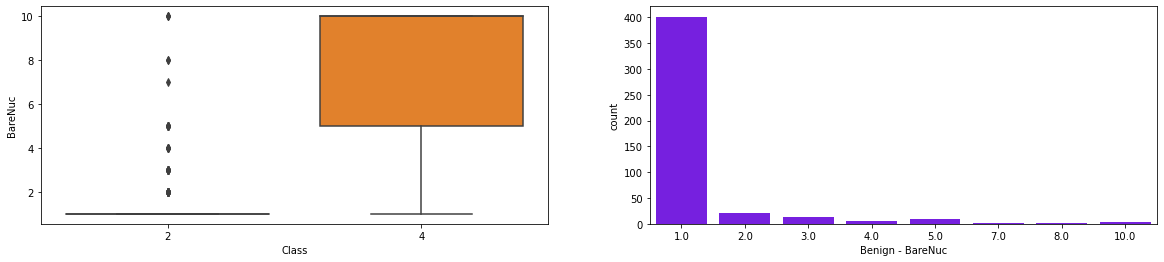

In [21]:
plot_box_and_count(df, 'BareNuc')
# UnifShape case is also similar to UnifSize

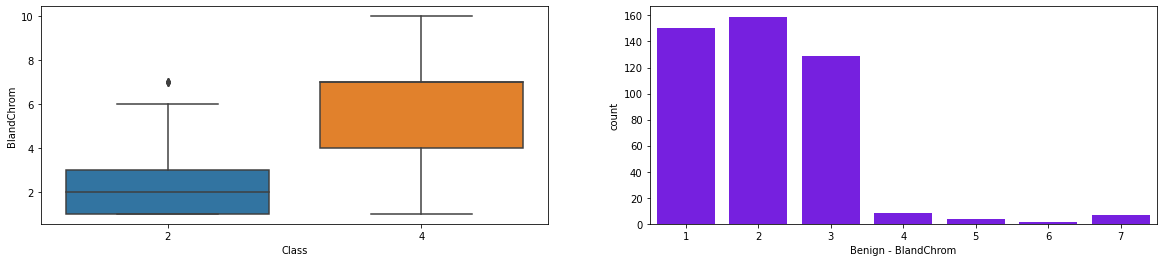

In [22]:
plot_box_and_count(df, 'BlandChrom')

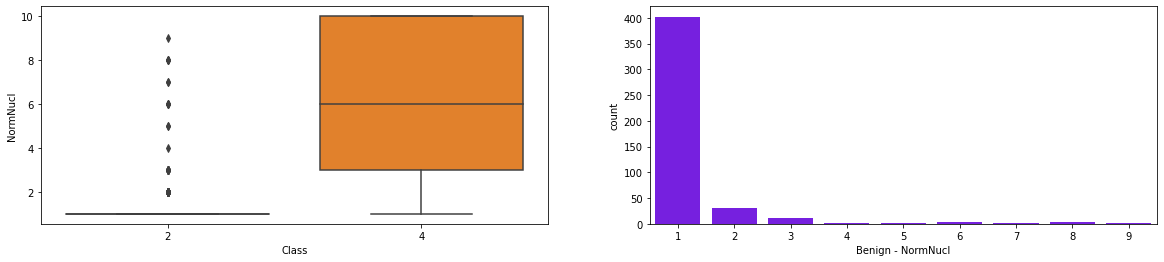

In [23]:
plot_box_and_count(df, 'NormNucl')

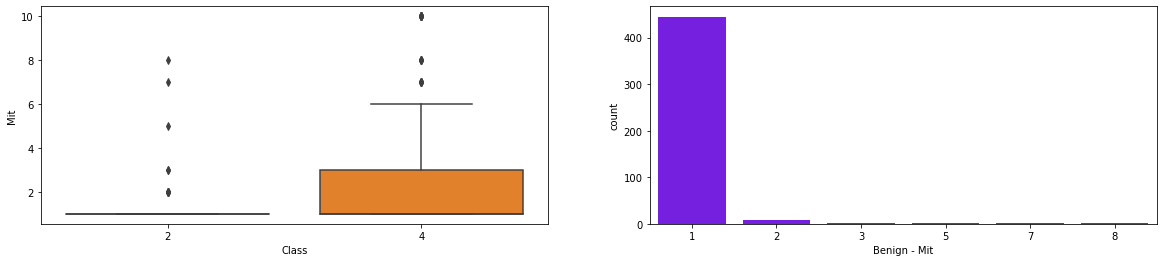

In [24]:
plot_box_and_count(df, 'Mit')

For `benign` except for `BlandChrom` column, all other columns data is highly concentrated to a specific value

## Modelling

In [25]:
# Shuffling the dataset
dataset = df.sample(frac=1, random_state=0)

features = dataset.columns.tolist()
features.remove('Class')

x = dataset[features]
y = dataset[['Class']]

In [26]:
benign_pct    = round(len(y[y.Class == 2]) / len(y), 2) * 100 
malignant_pct = round(len(y[y.Class == 4]) / len(y), 2) * 100 
print(f"Our dataset contains {benign_pct}% benign data and {malignant_pct}% malignant data")

Our dataset contains 66.0% benign data and 34.0% malignant data


In [27]:
# Splitting the dataset (15% as test dataset)
x_train, x_test, y_train, y_test = train_test_split(x, y.values.ravel(), test_size=0.15, random_state=0)

In [28]:
skf = StratifiedKFold(n_splits=3)

In [29]:
score = cross_val_score(LassoCV(), x_train, y_train, cv=skf)
print(f'LassoCV: {score.mean()}')

score = cross_val_score(SVC(), x_train, y_train, cv=skf)
print(f'SVM(SVC): {score.mean()}')

LassoCV: 0.8281590397440844
SVM(SVC): 0.9646464646464646


In [30]:
# Parameter tuning

def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    kernels = ['linear', 'rbf']
    param_grid = {
        'C': Cs, 
        'gamma' : gammas, 
        'kernel': kernels
    }
    
    grid_search = GridSearchCV(SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_


best_params_ = svc_param_selection(x_train, y_train, skf)
best_params_

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}

In [31]:
# Cross Validation
score = cross_val_score(SVC(C=1, gamma=0.01, kernel='rbf'), x_train, y_train, cv=skf)
print(f'SVM(SVC): {score.mean()}')

SVM(SVC): 0.9646464646464646


NOTE: Recursive Feature Selection cannot not be done on `rbf` kernel of SVM

If number of features are comparable or even greater than the number of training examples(observations) then the dataset is said to be `high dimensional` or `wide`. When training with high dimensional data we get complex models that will fit the data & in extreme case you can create a model that will exactly predict the training data but at a cost of poorly generalizing. This is not good.

To deal with high dimensional data we can use either `Feature Selection` or `Dimensionality Reduction`.

There are 3 types of feature selection methods
- `Filter`: It is applied before training a model, where you use statistical properties of the features to remove those data with low predictive power and then use this data to train model
- `Wrapper`: It trains multiple model with different combinations of training data and models and gives the best training data with best model
- `Embedded`: It does feature selection while training the model, the result is model that emphasis on most useful featrues.

[Source](https://www.coursera.org/lecture/predictive-modeling-machine-learning/embedded-methods-for-feature-selection-Q9LnS) to know more about `embedded feature selection`.


#### Using embedded method for feature selection

In [32]:
reg = LassoCV()

reg.fit(x_train, y_train)
print(f'Best regularization parameter using built-in LassoCV: {reg.alpha_}')
print(f'Best score using built-in LassoCV: {reg.score(x_train, y_train)}')

coef = pd.Series(reg.coef_, index = x_train.columns)
coef

Best regularization parameter using built-in LassoCV: 0.031983445283669094
Best score using built-in LassoCV: 0.8364856912033988


Clump          0.065597
UnifSize       0.044891
UnifShape      0.033253
MargAdh        0.014070
SingEpiSize    0.012444
BareNuc        0.086892
BlandChrom     0.040159
NormNucl       0.035733
Mit            0.000000
dtype: float64

In [33]:
print(f'Lasso picked {sum(coef != 0)} variables and eliminated the other {sum(coef == 0)} variables')

Lasso picked 8 variables and eliminated the other 1 variables


<AxesSubplot:>

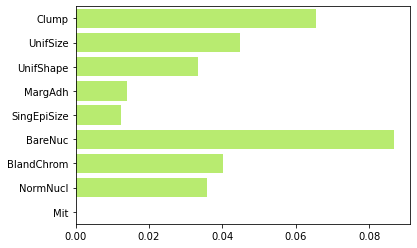

In [34]:
sns.barplot(x=coef, y=coef.index, orient='h', color='#bbff5c')

Here Lasso model has taken all the features, except Mit so we will remove that feature

#### Using Backward Elimination for feature selection

[Source_1](https://towardsdatascience.com/backward-elimination-for-feature-selection-in-machine-learning-c6a3a8f8cef4) and [Source_2](https://medium.com/@mayankshah1607/machine-learning-feature-selection-with-backward-elimination-955894654026) to know more about `backward elimination` 

In [35]:
x_1 = sm.add_constant(x_train)

# Fitting sm.OLS model
sm_model = sm.OLS(y_train, x_1).fit()
sm_model.pvalues

const          2.381329e-176
Clump           2.861026e-17
UnifSize        3.574851e-03
UnifShape       1.848212e-02
MargAdh         7.304446e-02
SingEpiSize     9.902671e-02
BareNuc         3.671993e-31
BlandChrom      6.902807e-05
NormNucl        7.822861e-06
Mit             9.614491e-01
dtype: float64

In [36]:
# Backward Elimination

def backward_elminiation(x_train, y_train):
    columns = list(x_train.columns)
    p_max = 1
    
    while len(columns) > 0:
        p = []

        x_1 = x_train[columns]
        x_1 = sm.add_constant(x_1)  # `add_constant`: Add a column of ones to an array
        
        # Fitting sm.OLS model
        model = sm.OLS(y_train, x_1).fit()
        
        # p-values
        p = pd.Series(model.pvalues.values[1:], index=columns)
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        
        # if p-value (significance) 0.05 (5%) then remove the column
        if pmax > 0.05:
            columns.remove(feature_with_p_max)
        else:
            break
            
    selected_features_BE = columns
    print(selected_features_BE)
        

backward_elminiation(x_train, y_train)

['Clump', 'UnifSize', 'UnifShape', 'BareNuc', 'BlandChrom', 'NormNucl']


#### Selecting the best features from embedded method and backward elimination

In [37]:
# From embedded method
emb_features = ['Clump', 'UnifSize', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'SingEpiSize', 'MargAdh', 'UnifShape']

# From backward elimination 
bem_features = ['Clump', 'UnifSize', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl']

In [38]:
# Doing Cross Validation on emb_features


emb_x_train = x_train[emb_features]
emb_y_train = y_train.copy()

emb_cv_clf = SVC(C=1, kernel='rbf', gamma=0.001)
scores = cross_val_score(emb_cv_clf, emb_x_train, emb_y_train, cv=skf)
emb_best_params_ = svc_param_selection(x_train, y_train, skf)
print(emb_best_params_)
print(f'Embeeded Method Features mean score: {round(scores.mean(), 4)}')


print()


bem_x_train = x_train[bem_features]
bem_y_train = y_train.copy()

bem_cv_clf = SVC(C=1, kernel='rbf', gamma=0.001)
scores = cross_val_score(bem_cv_clf, bem_x_train, bem_y_train, cv=skf)
bem_best_params_ = svc_param_selection(x_train, y_train, skf)
print(bem_best_params_)
print(f'Backward Elimination Features mean score: {round(scores.mean(), 4)}')

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Embeeded Method Features mean score: 0.9596

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Backward Elimination Features mean score: 0.9613


In [39]:
# Selecting features which gave the highest cross-validation mean score

final_features = ['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']
target = ['Class']

x_train = x_train[final_features]
x_test = x_test[final_features]

In [40]:
svc_param_selection(x_train, y_train, skf)

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}

In [41]:
# Cross Validation
score = cross_val_score(SVC(C=1, gamma=0.001, kernel='rbf'), x_train, y_train, cv=skf)
print(f'SVM(SVC): {score.mean()}')

SVM(SVC): 0.9663299663299663


In [42]:
# Plotting learning curve

_size = np.arange(0.01, 1.01, 0.06)
train_sizes = np.array(_size)
scoring = 'neg_mean_squared_error'

train_sizes_abs, train_scores, cv_scores = learning_curve(
    SVC(C=1, gamma=0.001, kernel='rbf'), 
    x_train, y_train, 
    train_sizes=train_sizes, cv=skf, scoring=scoring
)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py", line 173, in fit
    y = self._validate_targets(y)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py", line 560, in _validate_targets
    " class" % len(cls))
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call las

In [43]:
train_scores_mean = []
for row in train_scores:
    _mean = row.mean()
    train_scores_mean.append(_mean)
    
cv_scores_mean = []
for row in cv_scores:
    _mean = row.mean()
    cv_scores_mean.append(_mean)    
    
train_scores_mean = -np.array(train_scores_mean)
cv_scores_mean = -np.array(cv_scores_mean)

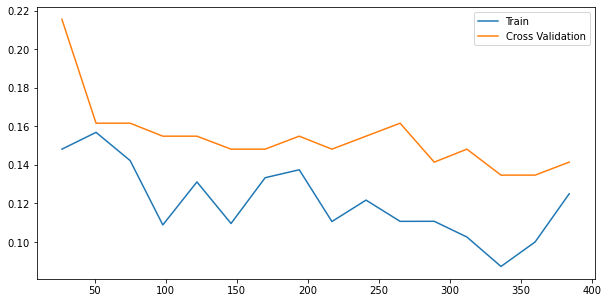

In [44]:
f, ax = plt.subplots(figsize=(10, 5))

ax.plot(train_sizes_abs, train_scores_mean, label='Train')
ax.plot(train_sizes_abs, cv_scores_mean, label='Cross Validation')

ax.legend()

In [45]:
# Fitting model

model = SVC(C=1, gamma=0.001, kernel='rbf')
model.fit(x_train, y_train)

SVC(C=1, gamma=0.001)

## Evaluation

In [46]:
y_test_pred = model.predict(x_test)

In [47]:
# Metrics

print(model.score(x_test, y_test))
print(f1_score(y_test, y_test_pred, average="weighted"))
print(precision_score(y_test, y_test_pred, average="weighted"))
print(recall_score(y_test, y_test_pred, average="weighted"))

0.9809523809523809
0.9809523809523809
0.9809523809523809
0.9809523809523809


In [48]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    '''
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
    '''

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=10)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i, format(cm[i, j], fmt),
            horizontalalignment='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           2       0.99      0.99      0.99        68
           4       0.97      0.97      0.97        37

    accuracy                           0.98       105
   macro avg       0.98      0.98      0.98       105
weighted avg       0.98      0.98      0.98       105

Confusion matrix, without normalization
[[67  1]
 [ 1 36]]


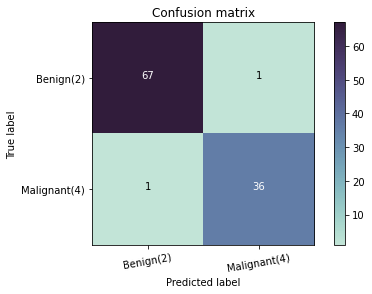

In [49]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=[2,4])
np.set_printoptions(precision=2)

print(classification_report(y_test, y_test_pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

In [50]:
# Pipeline

scaling = ('scale', StandardScaler())
model = ('model', SVC(C=1, gamma=0.001, kernel='rbf'))

# Steps in the pipeline
steps = [scaling, model]

# Instantiating pipeline
pipe = Pipeline(steps=steps)

# Fiitting the model
model = pipe.fit(x_train, y_train)

# Out-Of-Sample Forecast
y_test_pred = model.predict(x_test)

# Evaluation
print(f'Model Score: {model.score(x_test, y_test)}')
print(f'f1-score: {f1_score(y_test, y_test_pred, average="weighted")}')
print(f'precision score: {precision_score(y_test, y_test_pred, average="weighted")}')
print(f'recall score: {recall_score(y_test, y_test_pred, average="weighted")}')

Model Score: 0.9619047619047619
f1-score: 0.961651713825627
precision score: 0.9621768707482994
recall score: 0.9619047619047619


In [51]:
# Saving the model
dump(model, 'model.joblib')

['model.joblib']

---

I'll wrap things up there. If you want to find some other answers then go ahead `edit` this kernel. If you have any `questions` then do let me know.

If this kernel helped you then don't forget to 🔼 `upvote` and share your 🎙 `feedback` on improvements of the kernel.

![](https://media.giphy.com/media/qTD9EXZRgI1y0/giphy.gif)

---